In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [5]:
dataset.target

array([17,  0, 17, ...,  9,  4,  9])

In [7]:
dataset

{'data': ["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
  "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a l

<h2>1. Introduction</h2>

This dataset has 41,000 comments in portuguese and 100,000 review scores about ecommerce orders in Brazil. But what costumers are praising or complaining about? Delivering time? Packaging? Missing items? Product quality?

Altough the kernel name, I'll be using topic extraction to find a few topics that represent the costumers opinions. With this approach there is no distance metric and we are not actually using a clustering algorithm, but a dimensionality reduction technique.

Another approach would be training a classifier to predict some category for each review, but this has a few problems:

* Manually labelling thousands of comments for training
* Different analysts could introduce bias
* Fixed number of categories

First let's have a quick look at the reviews dataset. I'm removing all reviews that doesn't have a comment through python regular expression.

In [1]:
import pandas as pd
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
reviews['num_letters'] = reviews.review_comment_message.str.count('[a-zA-Z]')
reviews = reviews[reviews.num_letters > 0]  # Filter valid comments
reviews.head(3)

review_id                          order_id  \
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
9  8670d52e15e00043ae7de4c01cc2fe06  b9bf720beb4ab3728760088589c62129   

   review_score review_comment_title  \
3             5                  NaN   
4             5                  NaN   
9             4            recomendo   

                              review_comment_message review_creation_date  \
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
9  aparelho eficiente. no site a marca do aparelh...  2018-05-22 00:00:00   

  review_answer_timestamp  num_letters  
3     2017-04-21 22:02:06         31.0  
4     2018-03-02 10:26:53         82.0  
9     2018-05-23 16:45:47        139.0

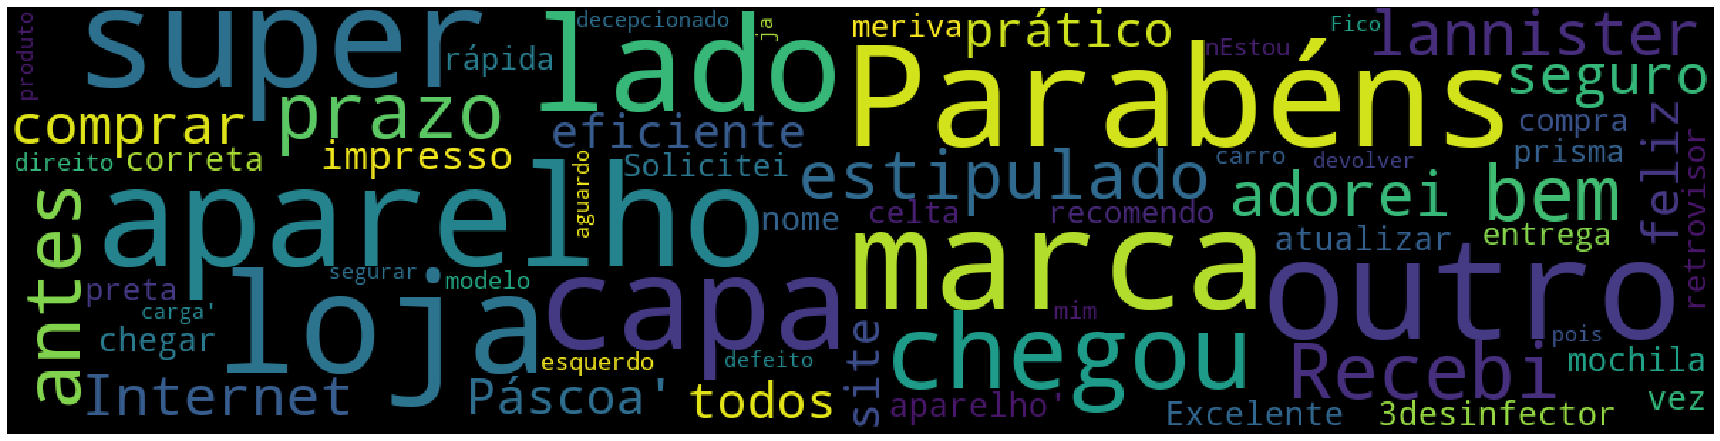

In [4]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
plt.figure(figsize=(24,16))
stop_words = stopwords.words('portuguese')
comments = reviews.review_comment_message.values
wordcloud = WordCloud(background_color='black',
                     stopwords=stop_words,
                     max_words=200,
                     max_font_size=100,
                     random_state=520,
                     width=1200,
                     height=300,
                     mask=None)
wordcloud.generate(str(comments))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()

<h3>1.1 Text Exploratory Analysis</h3>

For a complete exploration on all datasets you can check [this kernel](https://www.kaggle.com/jsaguiar/e-commerce-exploratory-analysis).

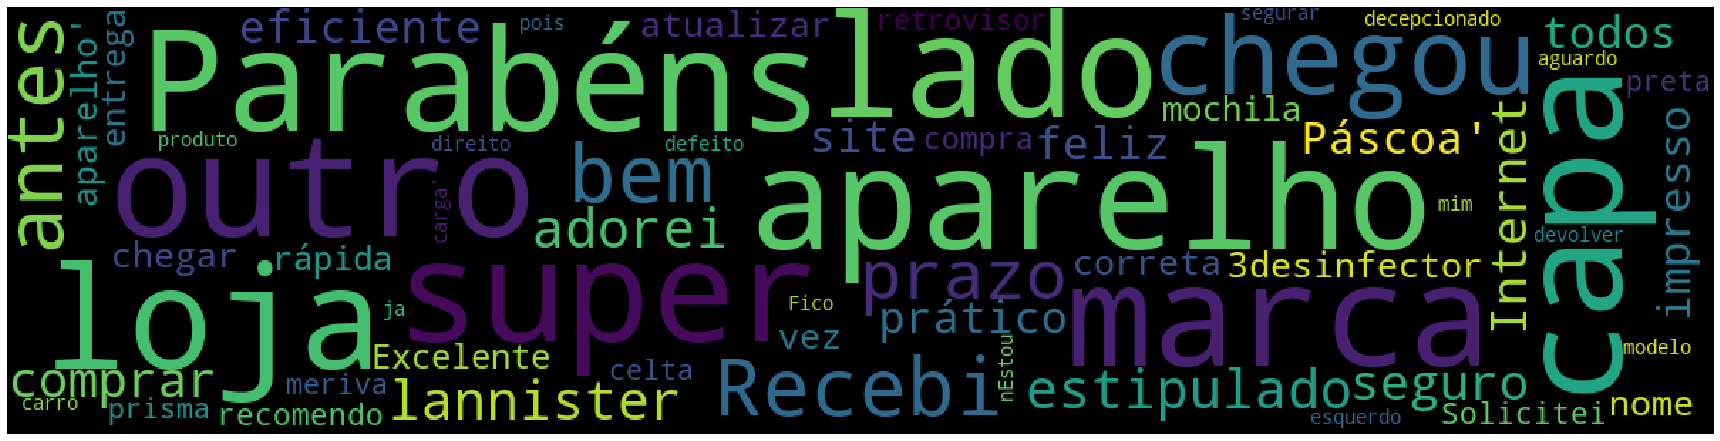

In [3]:
import re
import numpy as np
# Nlp
import nltk
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import TSNE
# Plots
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools, figure_factory
init_notebook_mode(connected=True)
# Wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_wordcloud(text, stopwords, mask=None, max_words=200, max_font_size=100,
                   title=None, title_size=40, image_color=False):

    figure_size = (24, 16)
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=1200, 
                    height=300,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

stopwords = nltk.corpus.stopwords.words('portuguese')
comments = reviews.review_comment_message.values
plot_wordcloud(comments, stopwords, title="")

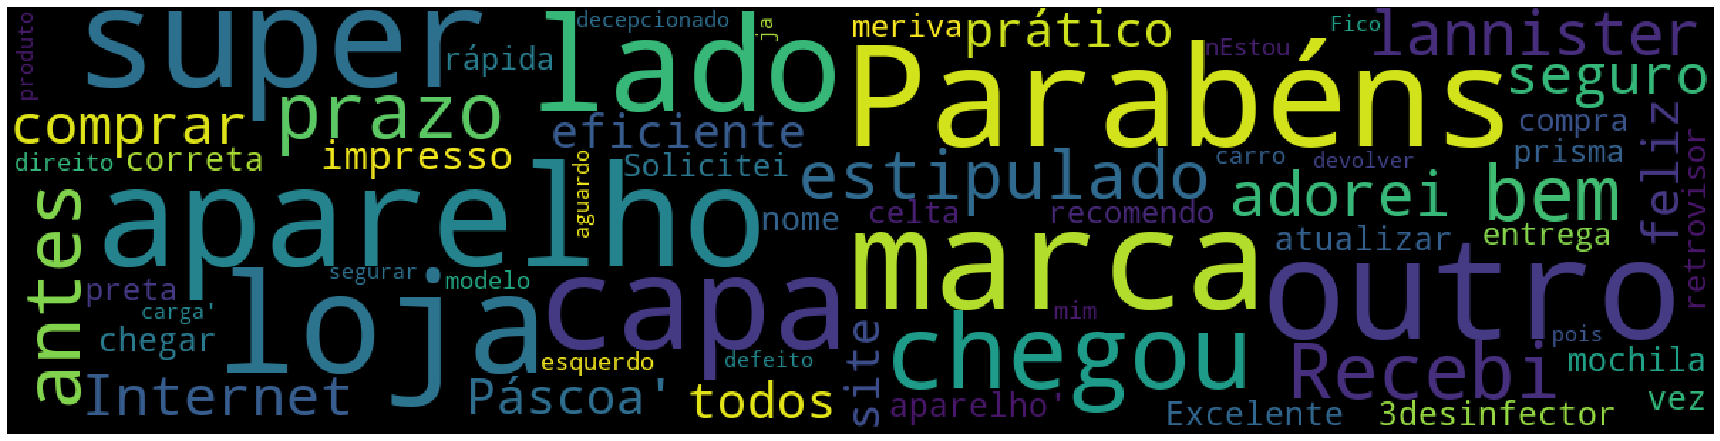

In [8]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
plt.figure(figsize=(24,16))
stop_words = stopwords.words('portuguese')
comments = reviews.review_comment_message.values
wordcloud = WordCloud(background_color='black',
                     stopwords=stop_words,
                     max_words=200,
                     max_font_size=100,
                     random_state=520,
                     width=1200,
                     height=300,
                     mask=None)
wordcloud.generate(str(comments))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()

Let's have a look at the most common words and trigrams:

In [9]:
from collections import defaultdict

def generate_ngrams(text, stopwords, n_gram=1):
    token = [w.lower() for sent in nltk.sent_tokenize(text) for w in nltk.word_tokenize(sent)]
    # Remove stopwords and ponctuation
    token = [t for t in token if re.search('[a-zA-Z]', t) and t not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Count words
freq_dict = defaultdict(int)
for sent in comments:
    for word in generate_ngrams(sent, stopwords):
        freq_dict[word] += 1
wdf = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1],
                   columns=["word", "word_count"])

# Count Trigrams
freq_dict = defaultdict(int)
for sent in comments:
    for word in generate_ngrams(sent, stopwords, 3):
        freq_dict[word] += 1
tdf = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1],
                   columns=["trigram", "trigram_count"])

# Sort and filter top 12
tdf = tdf.sort_values(by='trigram_count', ascending=False).iloc[:12]
wdf = wdf.sort_values(by='word_count', ascending=False).iloc[:12]

trace0 = go.Bar(
    y=wdf.word.values,
    x=wdf.word_count.values,
    name='Number of words',
    orientation='h',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    y=tdf.trigram.values,
    x=tdf.trigram_count.values,
    name='Number of trigrams',
    orientation='h',
    marker=dict(color='rgb(204,204,204)')
)
fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(
    height=600, width=800,
    title='Words and trigrams in reviews',
    margin=dict(l=150, r=10, t=100, b=100),
    legend=dict(orientation="h")
)
fig['layout']['xaxis1'].update(domain=[0, 0.40])
fig['layout']['xaxis2'].update(domain=[0.6, 1])
iplot(fig)

/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



It seems that most comments are at least mentioning delivery time. Now let's have a look at some text statistics:

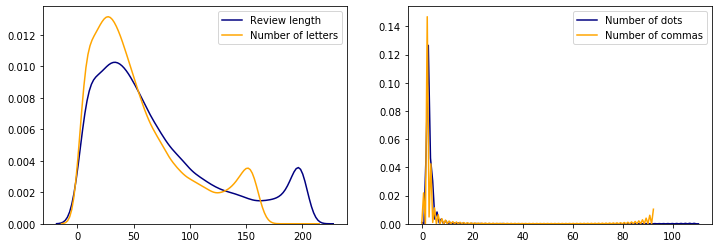

In [10]:
length = [len(text) for text in comments]
num_letters = [len(re.findall(r'[a-zA-Z]', text)) for text in comments]
num_commas = [text.count(',') for text in comments]
num_dots = [text.count('.') for text in comments]

fig, axis = plt.subplots(1, 2, figsize=(12,4))
pl0 = sns.kdeplot(length, color='navy', label='Review length', ax=axis[0])
pl1 = sns.kdeplot(num_letters, color='orange', label='Number of letters', ax=axis[0])
pl2 = sns.kdeplot(num_dots, color='navy', label='Number of dots', ax=axis[1])
pl3 = sns.kdeplot(num_commas, color='orange', label='Number of commas', ax=axis[1])

Some customers really like dots... Finally, let's check the review scores:

In [11]:
review_count = reviews.review_score.value_counts()
trace = go.Bar(x=review_count.index, y=review_count.values)
layout = go.Layout(title='Review scores distribution', height=360, width=800)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<h2>2. Text Preprocessing</h2>

The first step is to transform comments in tokens. We also need to apply a few preprocessing steps like removing common words and correcting spelling mistakes. These steps must be implemented as classes and will be grouped using a sklearn pipeline in the next section. The first class is just for selecting columns in our data:

In [12]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key."""
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_):
        return data_[self.key].values

<h3>2.1 Stopwords</h3>

Removing common words like 'the' and 'is' usually improves the model since these words doesn't help to distinguish between documents. I'll be using the portuguese stopwords from NLTK with a few extra elements.

In [13]:
class RemoveStopwords(BaseEstimator, TransformerMixin):
    """Remove stopwords from list of tokens list."""
    def fit(self, x, y=None):
        return self

    def transform(self, comments):
        stopwords = nltk.corpus.stopwords.words('portuguese')
        stopwords.extend(['é', 'ok', 'ta', 'tá', 'att', 'att.', 'sr', 'porém',
                          'produto', 'recomendo'])
        return [[tk for tk in tokens if tk not in stopwords] for tokens in comments]

<h3>2.2 Spelling mistakes</h3>

There are a few algorithms to correct spelling mistakes, but I'll be doing this manually.

In [14]:
class CorrectSpelling(BaseEstimator, TransformerMixin):
    """Fix a few spelling mistakes in tokens."""
    def fit(self, x, y=None):
        return self

    def transform(self, comments):
        mistakes_dict = {
            'decpcionou': 'decepcionou', 'tô': 'estou', 'to': 'estou',
            'q': 'que', 'pq': 'porque', 'mt': 'muito', 'muiiita': 'muita',
            'estaav': 'estava', 'acabento': 'acabamento', 'orrivel': 'horrível',
            'sertões': 'certos', 'vcs': 'vocês', 'msg': 'mensagem', 'dta': 'data',
            'ñ': 'não', 'n': 'não', 'grates': 'grátis', 'testa-lo': 'testar',
            'superandoo': 'superando', 'atentimento': 'atendimento',
            'cancelacem': 'cancelassem', 'msm': 'mesmo', 'protudo': 'produto',
            'decrarar': 'declarar', 'trasporte': 'transporte', 'decpsionei': 'decepcionei',
            'empuerada': 'empoeirada', 'recebie': 'recebi', 'superr': 'super',
            'nao': 'não', 'mto': 'muito', 'tb': 'também', 'execelente': 'excelente',
            'tao': 'tão', 'blz': 'beleza'
        }
        return [[mistakes_dict[tk] if tk in mistakes_dict else tk for tk in tokens]
               for tokens in comments]

<h3>2.3 Stemming</h3>

> Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root. (Wikipedia)

The goal of stemming algorithms is to group related words and to separate unrelated words. More information about the portuguese stemmer can be find in [this link](https://snowballstem.org/algorithms/portuguese/stemmer.html).

In [15]:
class Stemmer(BaseEstimator, TransformerMixin):
    """Used to reduce words with the portuguese Snowball stemmer."""
    def fit(self, x, y=None):
        return self

    def transform(self, comments):
        #stemmer_ = nltk.stem.snowball.SnowballStemmer('portuguese')
        stemmer_ = nltk.stem.RSLPStemmer()
        return [[stemmer_.stem(tk) for tk in tokens] for tokens in comments]

<h3>2.4 Tokenize</h3>

Return a list for each comment with tokens and remove the ones that doesn't have letters (like !! or ...)

In [16]:
class Tokenize(BaseEstimator, TransformerMixin):
    """Class to tokenize comments."""
    def fit(self, x, y=None):
        return self

    def transform(self, comments):
        tokenized_comments = list()
        for text in comments:
            # Tokenize and lower
            tokens = [w.lower() for sent in nltk.sent_tokenize(text) for w in nltk.word_tokenize(sent)]
            # Filter tokens that doesn't have letters
            tokens = [t for t in tokens if re.search('[a-zA-Z]', t)]
            tokenized_comments.append(tokens)
        return tokenized_comments

<h3>2.5 Vectorize</h3>

Finally we need to convert words to numbers. I'll use two transformers that are already implemented in Sklearn library:

<b>Count Vectorizer</b>

> Count the number of words in each document (review) and return a matrix where each column is a word and each row is a review. To save memory, sklearn return a sparse matrix object (scipy.sparse.csr_matrix).

<b>TF-IDF</b>

> Term frequency–inverse document frequency is a numerical statistic that is intended to reflect how important a word is to a document in a collection. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word (Wikipedia).

Both are considered bag-of-words representations, which doesn't consider the order and consequently the sentence meaning. However, it's possible to create good topic models using only the frequency of words in each document. 

<h2>3. Topic Modeling</h2>

Topic model is a type of statistical model for discovering the abstract topics that occur in a collection of documents. The number of topics is considered a hyperparameter, which I choose by looking at the topics that were being created. I've also tryed to use the perplexity metric for finding the optimal number, but it didn't work very well.

In [17]:
def print_top_words_for_topic(components, feature_names, num_words):
    """Print top words for each topic in components vector."""
    for topic_idx, topic in enumerate(components):
        message = "Topic #%d: " % (topic_idx + 1)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])
        print(message)

num_topics = 3
rnd_state = 125

<h3>3.1 Latent Semantic Analysis (LSA)</h3>

The key idea of LSA is to map documents (and by symmetry terms) to a vector space of reduced dimensionality. The mapping is restricted to be linear and is based on a Singular Value Decomposition (SVD), which is also used in Principal Component Analysis. 

In [18]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to /Users/chenzhou/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [19]:
lsa_pipeline = Pipeline([
    ('selector', ItemSelector(key='review_comment_message')),
    ('tokenize', Tokenize()),
    ('spelling', CorrectSpelling()),
    ('stopwords', RemoveStopwords()),
    ('stemming', Stemmer()),
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x,
                              analyzer='word', min_df=2, max_df=0.95)),
    ('reduce', TruncatedSVD(n_components=num_topics, random_state=rnd_state))
])

lsa_matrix = lsa_pipeline.fit_transform(reviews)
# Get words and components from pipeline transformers
feat_names = lsa_pipeline.get_params()['tfidf'].get_feature_names()
components = lsa_pipeline.get_params()['reduce'].components_
# Print the 8 most important words for each topic
print_top_words_for_topic(components, feat_names, 8)

Topic #1: bom praz entreg ant cheg ótim rápid bem
Topic #2: bom preç som benefici comp atendment esquent prec
Topic #3: ótim rápid qual entreg sup excel loj atend


<h3>3.2 Probabilistic Latent Semantic Analysis (pLSA)</h3>

The crucial difference between pLSA and LSA is the objective function utilized to determine the optimal decomposition. In LSA, this is the L2-norm (or [Frobenius Norm](http://mathworld.wolfram.com/FrobeniusNorm.html) or matrix norm), while pLSA relies on the likelihood function of multinomial sampling ([Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)). 

PLSA is a non-linear model based on probability distributions. The output is the distribution over a fixed vocabulary, where every topic has a probability for every word. It's important to note that the same word can have a high probability for multiple topics. For a detailed explanation please refer to the [original paper](http://www.iro.umontreal.ca/~nie/IFT6255/Hofmann-UAI99.pdf).


In [20]:
plsa_pipeline = Pipeline([
    ('selector', ItemSelector(key='review_comment_message')),
    ('tokenize', Tokenize()),
    ('spelling', CorrectSpelling()),
    ('stopwords', RemoveStopwords()),
    ('stemming', Stemmer()),
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x,
                              analyzer='word', min_df=2, max_df=0.95)),
    ('reduce', NMF(n_components=num_topics, random_state=rnd_state, solver='mu',
                   beta_loss='kullback-leibler', alpha=0.1, l1_ratio=0.5))
])

plsa_matrix = plsa_pipeline.fit_transform(reviews)
# Get words and components from pipeline transformers
feat_names = plsa_pipeline.get_params()['tfidf'].get_feature_names()
components = plsa_pipeline.get_params()['reduce'].components_
# Print the 8 most important words for each topic
print_top_words_for_topic(components, feat_names, 8)

Topic #1: entreg ant praz compr cheg receb bem aind
Topic #2: bom preç benefici facil cust barat cheir som
Topic #3: entreg ótim qual rápid excel boa atend loj


<h3>3.2 Latent Dirichlet Allocation (LDA)</h3>

Latent Dirichlet Allocation is a generative statistical model similar to pLSA. The difference is that LDA uses an [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) to handle the per-document distribution, while in PLSA this is given by a hyperparameter. This distribution should also prevent overfitting (in theory).

In [21]:
lda_pipeline = Pipeline([
    ('selector', ItemSelector(key='review_comment_message')),
    ('tokenize', Tokenize()),
    ('spelling', CorrectSpelling()),
    ('stopwords', RemoveStopwords()),
    ('stemming', Stemmer()),
    ('countvec', CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x,
                                 analyzer='word', min_df=2, max_df=0.95)),
    ('reduce', LatentDirichletAllocation(n_components=num_topics,
                                         random_state=rnd_state))
])

lda_matrix = lda_pipeline.fit_transform(reviews)
# Get words and components from pipeline transformers
feat_names = lda_pipeline.get_params()['countvec'].get_feature_names()
components = lda_pipeline.get_params()['reduce'].components_
# Print the 8 most important words for each topic
print_top_words_for_topic(components, feat_names, 8)

Topic #1: receb compr vei aind ped dia outr cheg
Topic #2: entreg praz compr rápid loj ótim gost atend
Topic #3: praz cheg ant bom bem qual tud perfeit


<h2>4. Visualization with t-SNE</h2>

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It's not a linear model and does not retain distances but probabilities. For more information please refer to [this github page](https://lvdmaaten.github.io/tsne/).

In [22]:
def scatter_plot(arr, tsne_arr, threshold=0):
    idx = np.amax(arr, axis = 1) >= threshold
    colors = [row.argmax() for row in arr[idx]]
    trace = go.Scattergl(x=tsne_arr[idx, 0], y=tsne_arr[idx, 1],
                         mode='markers', marker=dict(color=colors))
    iplot([trace])

In [23]:
lr = 150
# LSA
lsa_tsne = TSNE(n_components=2, learning_rate=lr).fit_transform(lsa_matrix)
scatter_plot(lsa_matrix, lsa_tsne)

# pLSA
plsa_tsne = TSNE(n_components=2, learning_rate=lr).fit_transform(plsa_matrix)
scatter_plot(plsa_matrix, plsa_tsne)

# LDA
lda_tsne = TSNE(n_components=2, learning_rate=lr).fit_transform(lda_matrix)
scatter_plot(lda_matrix, lda_tsne, threshold=0.5)

KeyboardInterrupt: 

<h2>5. Quick Conclusion</h2>

The challenge here is that most comments are related to delivery time or just praise/criticism without a specific topic. However, we can see that the first topic was about delivery, while the second was mainly about price and quality service. The third topic was mixed, with words like quality, store and delivery again. Another issue is the difficulty to evaluate unsupervised methods, since we don't have a straightforward metric to measure it.